<a href="https://colab.research.google.com/github/ManojKumarTiwari/Tensorflow2AndKeras/blob/master/4_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content
- Overview
- Imports

# Overview
- What is RNN?
  - time frame (time step)
  - recurrent neuron
  - memory cell(cell)
    - typical stores 10 step but depends on task
  - output and cell state
- What are some of the use cases?
- What are the problems associated with RNNs?
- How to fix those problems?
- Types of RNNs based on Input and Output
  - seq2seq
  - seq2vec
  - vec2seq
  - encoder-decoder
- Time series
  - univariate time series
  - multivariate time series
    - Things we can do
      - Forecasting
      - Postdict (Imputation)
- Backpropagation throught time (BPTT)

# Imports

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Scaling
from sklearn.preprocessing import MinMaxScaler

In [0]:
# !pip install --upgrade tensorflow-gpu

In [4]:
import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [0]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

# Dataset
- We will be working with historical data of Google which we can get from yahoo finance

# Load the Data

In [0]:
raw_data = pd.read_csv('GOOG.csv', date_parser=True)

In [10]:
raw_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [11]:
raw_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3938,2020-04-13,1209.180054,1220.510010,1187.598022,1217.560059,1217.560059,1739800
3939,2020-04-14,1245.089966,1282.069946,1236.930054,1269.229980,1269.229980,2470400
3940,2020-04-15,1245.609985,1280.459961,1240.400024,1262.469971,1262.469971,1671700
3941,2020-04-16,1274.099976,1279.000000,1242.619995,1263.469971,1263.469971,2507100
3942,2020-04-17,1284.849976,1294.430054,1271.229980,1283.250000,1283.250000,1947900


In [0]:
data = raw_data.copy() # always make a backup incase you make any mistakes during processing the data

# Data splitting
- For Training I will use data from starting date till the end of the year 2018
- For Validation I will use all the data in year 2019 
- And for Testing I will whatever data I have after 2019 (Which as of writing this notebook is till 2020-04-17

In [0]:
data_train = data[data['Date']<'2019-01-01']

In [14]:
data_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
...,...,...,...,...,...,...,...
3612,2018-12-24,973.900024,1003.539978,970.109985,976.219971,976.219971,1590300
3613,2018-12-26,989.010010,1040.000000,983.000000,1039.459961,1039.459961,2373300
3614,2018-12-27,1017.150024,1043.890015,997.000000,1043.880005,1043.880005,2109800
3615,2018-12-28,1049.619995,1055.560059,1033.099976,1037.079956,1037.079956,1414800


In [0]:
data_valid = data[(data['Date']>='2019-01-01') & (data['Date']<'2020-01-01')]

In [16]:
data_valid

,Date,Open,High,Low,Close,Adj Close,Volume
3617,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
3618,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
3619,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3620,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
3621,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900
...,...,...,...,...,...,...,...
3864,2019-12-24,1348.500000,1350.260010,1342.780029,1343.560059,1343.560059,347500
3865,2019-12-26,1346.170044,1361.327026,1344.469971,1360.400024,1360.400024,667500
3866,2019-12-27,1362.989990,1364.530029,1349.310059,1351.890015,1351.890015,1038400
3867,2019-12-30,1350.000000,1353.000000,1334.020020,1336.140015,1336.140015,1050900


In [0]:
data_test = data[data['Date']>='2020-01-01']

In [18]:
data_test

,Date,Open,High,Low,Close,Adj Close,Volume
3869,2020-01-02,1341.550049,1368.140015,1341.550049,1367.369995,1367.369995,1406600
3870,2020-01-03,1347.859985,1372.500000,1345.543945,1360.660034,1360.660034,1186400
3871,2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300
3872,2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1393.339966,1502700
3873,2020-01-08,1392.079956,1411.579956,1390.839966,1404.319946,1404.319946,1528000
...,...,...,...,...,...,...,...
3938,2020-04-13,1209.180054,1220.510010,1187.598022,1217.560059,1217.560059,1739800
3939,2020-04-14,1245.089966,1282.069946,1236.930054,1269.229980,1269.229980,2470400
3940,2020-04-15,1245.609985,1280.459961,1240.400024,1262.469971,1262.469971,1671700
3941,2020-04-16,1274.099976,1279.000000,1242.619995,1263.469971,1263.469971,2507100


# Data Preparation 

In [0]:
# Selecting only 'Open' feature and creating a univaiate time series
training_data = data_train.drop(['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [20]:
training_data

,Open
0,49.813286
1,50.316402
2,55.168217
3,55.412300
4,52.284027
...,...
3612,973.900024
3613,989.010010
3614,1017.150024
3615,1049.619995


In [27]:
# We need last 60 days of data from the data_train to predict the first day value in the validation dataset and similarly we need to add
# last 60 days of data from data_valid to predict the first day value in the testing dataset 

past_60_days_v = data_train.tail(60)

df_valid = past_60_days_v.append(data_valid, ignore_index=True)
df_valid

past_60_days_t = data_valid.tail(60)

df_test = past_60_days_t.append(data_test, ignore_index=True)
df_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,1204.400024,1218.203979,1203.750000,1207.680054,1207.680054,842900
1,2019-10-08,1197.589966,1206.079956,1189.010010,1189.130005,1189.130005,1039300
2,2019-10-09,1199.349976,1208.349976,1197.630005,1202.310059,1202.310059,867700
3,2019-10-10,1198.579956,1215.000000,1197.339966,1208.670044,1208.670044,846600
4,2019-10-11,1222.209961,1228.390015,1213.739990,1215.449951,1215.449951,1272700
...,...,...,...,...,...,...,...
129,2020-04-13,1209.180054,1220.510010,1187.598022,1217.560059,1217.560059,1739800
130,2020-04-14,1245.089966,1282.069946,1236.930054,1269.229980,1269.229980,2470400
131,2020-04-15,1245.609985,1280.459961,1240.400024,1262.469971,1262.469971,1671700
132,2020-04-16,1274.099976,1279.000000,1242.619995,1263.469971,1263.469971,2507100


In [0]:
validation_data = df_valid.drop(['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
testing_data = df_test.drop(['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [29]:
# Scaling the Data
scalar = MinMaxScaler()
training_data = scalar.fit_transform(training_data)
training_data
# This will return all values in range 0 to 1

array([[3.30294890e-04],
       [7.42148227e-04],
       [4.71386886e-03],
       ...,
       [7.92197108e-01],
       [8.18777193e-01],
       [8.19874096e-01]])

In [0]:
validation_data = scalar.transform(validation_data)
testing_data = scalar.transform(testing_data)

In [0]:
X_train = [] # Sequences of training data
y_train = [] # Vectors of Output

# We are taking 60 time step per sequence here, but you can take according to the use case
for i in range(60, training_data.shape[0]):
  X_train.append(training_data[i-60:i]) # Indexes included (0-59), (1-60), (2-61)...
  y_train.append(training_data[i]) # Indexes included 60,61,62...

In [0]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [33]:
X_train.shape, y_train.shape

((3557, 60, 1), (3557, 1))

In [0]:
n_steps = 60

In [0]:
X_valid = [] # Sequences of training data
y_valid = [] # Vectors of Output

# We are taking 60 time step per sequence here, but you can take according to the use case
for i in range(60, validation_data.shape[0]):
  X_valid.append(validation_data[i-60:i]) # Indexes included (0-59), (1-60), (2-61)...
  y_valid.append(validation_data[i]) # Indexes included 60,61,62...

In [0]:
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

In [0]:
X_test = [] # Sequences of training data
y_test = [] # Vectors of Output

# We are taking 60 time step per sequence here, but you can take according to the use case
for i in range(60, testing_data.shape[0]):
  X_test.append(testing_data[i-60:i]) # Indexes included (0-59), (1-60), (2-61)...
  y_test.append(testing_data[i]) # Indexes included 60,61,62...

In [0]:
X_test, y_test = np.array(X_test), np.array(y_test)

# seq2vec RNN for univariate time series to predict 1 time step ahead
- We will take consider only 'Open' column for now and thus giving a univariate time series. 
- Using this series we will create sequences of time series with 60 days of time step.
- Now using these sequences of time series we will try to predict the next value in the sequnce which is 1 time step ahead

So, basically we will be building a seq2vec RNN for univariate time series 

## Baseline Model
- Its just a Linear model that we will train to compare performace of our RNN with

In [0]:
model = Sequential()
model.add(Flatten(input_shape=[60, 1]))
model.add(Dense(1))

In [0]:
model.compile(optimizer=Adam(), loss=mse)

In [0]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
112/112 [==============================] - 0s 2ms/step - loss: 0.1387 - val_loss: 0.0034
Epoch 2/20
112/112 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 3/20
112/112 [==============================] - 0s 1ms/step - loss: 9.8873e-04 - val_loss: 0.0030
Epoch 4/20
112/112 [==============================] - 0s 1ms/step - loss: 8.5780e-04 - val_loss: 0.0027
Epoch 5/20
112/112 [==============================] - 0s 1ms/step - loss: 7.6060e-04 - val_loss: 0.0027
Epoch 6/20
112/112 [==============================] - 0s 1ms/step - loss: 7.0770e-04 - val_loss: 0.0025
Epoch 7/20
112/112 [==============================] - 0s 1ms/step - loss: 6.5923e-04 - val_loss: 0.0023
Epoch 8/20
112/112 [==============================] - 0s 1ms/step - loss: 6.3775e-04 - val_loss: 0.0023
Epoch 9/20
112/112 [==============================] - 0s 1ms/step - loss: 6.1294e-04 - val_loss: 0.0023
Epoch 10/20
112/112 [==============================] - 0s 1ms/step - los

In [0]:
model.evaluate(X_valid, y_valid)

6/6 [==============================] - 0s 1ms/step - loss: 0.0017


0.001729713287204504

In [0]:
history.history

{'loss': [0.1386675089597702,
  0.0011340954806655645,
  0.0009887301130220294,
  0.0008577993721701205,
  0.000760597933549434,
  0.000707702711224556,
  0.0006592322024516761,
  0.0006377469981089234,
  0.0006129353423602879,
  0.000598548911511898,
  0.0005913466447964311,
  0.0005747518735006452,
  0.000561971333809197,
  0.0005455074715428054,
  0.0005375876789912581,
  0.0005249558598734438,
  0.000507925811689347,
  0.0004985244595445693,
  0.0005061384872533381,
  0.00047764513874426484],
 'val_loss': [0.00341014307923615,
  0.0032693964894860983,
  0.0029509563464671373,
  0.0027139487210661173,
  0.002741831121966243,
  0.00248107872903347,
  0.0023239387664943933,
  0.0023037984501570463,
  0.002302114386111498,
  0.002192899351939559,
  0.0021536743734031916,
  0.0021139956079423428,
  0.0020696630235761404,
  0.0020058585796505213,
  0.0019867876544594765,
  0.0019062282517552376,
  0.0019156326306983829,
  0.002181095303967595,
  0.001777402125298977,
  0.0017297132872045

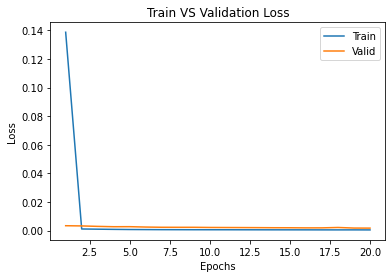

In [0]:
# Plot Training Loss vs Validation Loss
epochs = range(1,21)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title("Train VS Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'])
plt.show()

In [0]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

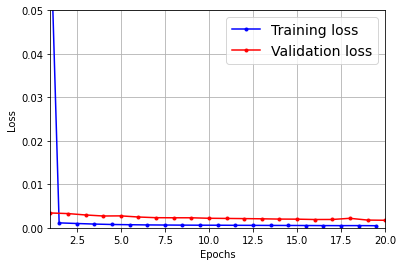

In [0]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    # plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
y_pred = model.predict(X_valid)

In [0]:
scalar.scale_

array([0.00081861])

In [0]:
scale = 1/scalar.scale_
scale

array([1221.590199])

In [0]:
y_pred_rev_s = y_pred*scale
y_valid_rev_s = y_valid*scale

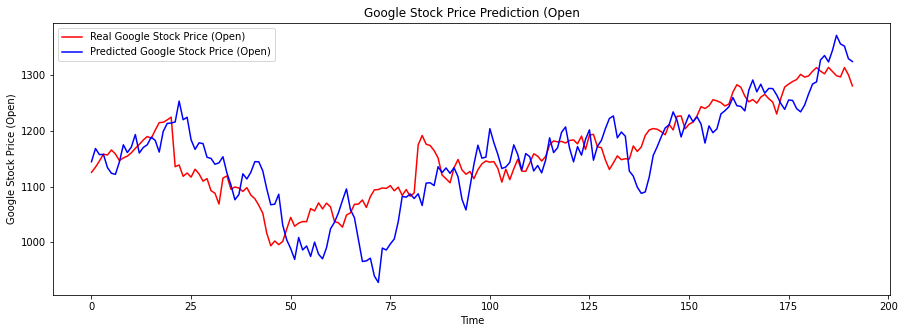

In [0]:
y_pred_rev_s = y_pred*scale

plt.figure(figsize=(15,5))
plt.plot(y_valid_rev_s, color='red', label='Real Google Stock Price (Open)')
plt.plot(y_pred_rev_s, color='blue', label='Predicted Google Stock Price (Open)')
plt.title('Google Stock Price Prediction (Open')
plt.xlabel('Time')
plt.ylabel('Google Stock Price (Open)')
plt.legend()
plt.show()

## Simple RNN

In [0]:
model = Sequential()
model.add(SimpleRNN(1, input_shape=[None,1]))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=Adam(learning_rate=0.005), loss=mse)

In [0]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
112/112 [==============================] - 1s 8ms/step - loss: 0.0300 - val_loss: 0.1078
Epoch 2/20
112/112 [==============================] - 1s 7ms/step - loss: 0.0113 - val_loss: 0.0684
Epoch 3/20
112/112 [==============================] - 1s 7ms/step - loss: 0.0066 - val_loss: 0.0467
Epoch 4/20
112/112 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0303
Epoch 5/20
112/112 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0215
Epoch 6/20
112/112 [==============================] - 1s 7ms/step - loss: 9.3827e-04 - val_loss: 0.0167
Epoch 7/20
112/112 [==============================] - 1s 7ms/step - loss: 7.3607e-04 - val_loss: 0.0146
Epoch 8/20
112/112 [==============================] - 1s 8ms/step - loss: 6.5758e-04 - val_loss: 0.0134
Epoch 9/20
112/112 [==============================] - 1s 7ms/step - loss: 6.4730e-04 - val_loss: 0.0129
Epoch 10/20
112/112 [==============================] - 1s 8ms/step - loss: 6.4454e-0

In [0]:
model.evaluate(X_valid, y_valid)

6/6 [==============================] - 0s 2ms/step - loss: 0.0124


0.012427066452801228

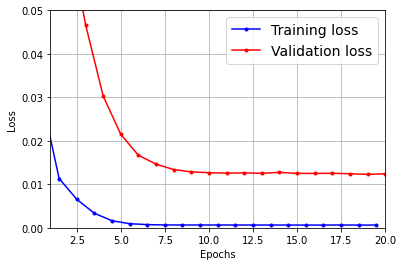

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
y_pred = model.predict(X_valid)

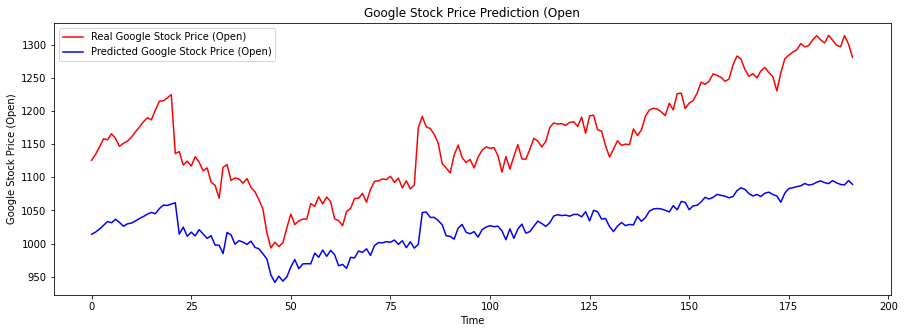

In [0]:
y_pred_rev_s = y_pred*scale

plt.figure(figsize=(15,5))
plt.plot(y_valid_rev_s, color='red', label='Real Google Stock Price (Open)')
plt.plot(y_pred_rev_s, color='blue', label='Predicted Google Stock Price (Open)')
plt.title('Google Stock Price Prediction (Open')
plt.xlabel('Time')
plt.ylabel('Google Stock Price (Open)')
plt.legend()
plt.show()

## Deep RNN

In [0]:
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True, input_shape=[60,1]))
model.add(SimpleRNN(20, return_sequences=True))
model.add(SimpleRNN(1))

In [0]:
model.compile(optimizer=Adam(learning_rate=0.005), loss=mse)

In [0]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
112/112 [==============================] - 3s 28ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 2/20
112/112 [==============================] - 3s 24ms/step - loss: 3.8643e-04 - val_loss: 0.0087
Epoch 3/20
112/112 [==============================] - 3s 25ms/step - loss: 4.3416e-04 - val_loss: 0.0088
Epoch 4/20
112/112 [==============================] - 3s 24ms/step - loss: 2.9570e-04 - val_loss: 0.0055
Epoch 5/20
112/112 [==============================] - 3s 24ms/step - loss: 2.5010e-04 - val_loss: 0.0055
Epoch 6/20
112/112 [==============================] - 3s 27ms/step - loss: 2.7157e-04 - val_loss: 0.0051
Epoch 7/20
112/112 [==============================] - 3s 26ms/step - loss: 2.0850e-04 - val_loss: 0.0052
Epoch 8/20
112/112 [==============================] - 3s 24ms/step - loss: 1.5508e-04 - val_loss: 0.0038
Epoch 9/20
112/112 [==============================] - 3s 25ms/step - loss: 1.5375e-04 - val_loss: 0.0036
Epoch 10/20
112/112 [==============================] - 3s 2

In [0]:
model.evaluate(X_valid, y_valid)

6/6 [==============================] - 0s 5ms/step - loss: 0.0049


0.004873501602560282

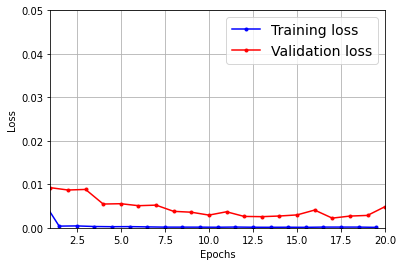

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
y_pred = model.predict(X_valid)

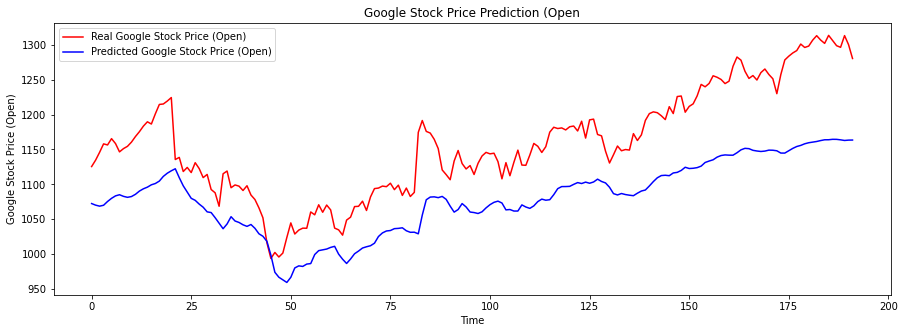

In [0]:
y_pred_rev_s = y_pred*scale

plt.figure(figsize=(15,5))
plt.plot(y_valid_rev_s, color='red', label='Real Google Stock Price (Open)')
plt.plot(y_pred_rev_s, color='blue', label='Predicted Google Stock Price (Open)')
plt.title('Google Stock Price Prediction (Open')
plt.xlabel('Time')
plt.ylabel('Google Stock Price (Open)')
plt.legend()
plt.show()

## Deep RNN + Dense
- Since we are predicting only one value, we can replace the last layer with dense layer.
- It will help in training time improvement
- We can apply any activation function we want
- Also it won't matter much cause most the data is passed by subseqent RNN layers

In [0]:
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True, input_shape=[60,1]))
model.add(SimpleRNN(20))
model.add(Dense(1))

In [0]:
model.compile(optimizer=Adam(learning_rate=0.005), loss=mse)

In [0]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
112/112 [==============================] - 2s 19ms/step - loss: 0.0143 - val_loss: 0.0019
Epoch 2/20
112/112 [==============================] - 2s 16ms/step - loss: 1.2695e-04 - val_loss: 5.9910e-04
Epoch 3/20
112/112 [==============================] - 2s 16ms/step - loss: 1.2939e-04 - val_loss: 8.0540e-04
Epoch 4/20
112/112 [==============================] - 2s 17ms/step - loss: 1.1070e-04 - val_loss: 3.5457e-04
Epoch 5/20
112/112 [==============================] - 2s 16ms/step - loss: 1.5352e-04 - val_loss: 0.0011
Epoch 6/20
112/112 [==============================] - 2s 16ms/step - loss: 1.4186e-04 - val_loss: 3.5882e-04
Epoch 7/20
112/112 [==============================] - 2s 17ms/step - loss: 1.8304e-04 - val_loss: 0.0017
Epoch 8/20
112/112 [==============================] - 2s 18ms/step - loss: 1.9689e-04 - val_loss: 4.0385e-04
Epoch 9/20
112/112 [==============================] - 2s 17ms/step - loss: 1.6622e-04 - val_loss: 4.4753e-04
Epoch 10/20
112/112 [==============

In [0]:
model.evaluate(X_valid, y_valid)

6/6 [==============================] - 0s 4ms/step - loss: 3.2956e-04


0.0003295635979156941

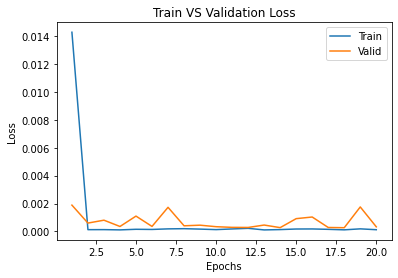

In [0]:
# Plot Training Loss vs Validation Loss
epochs = range(1,21)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title("Train VS Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'])
plt.show()

In [0]:
y_pred = model.predict(X_valid)

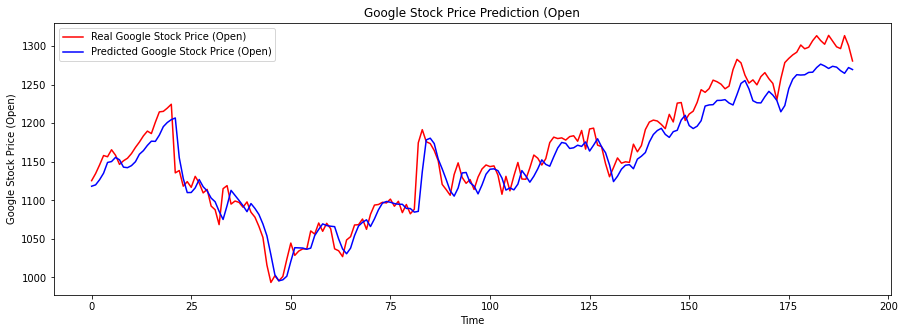

In [0]:
y_pred_rev_s = y_pred*scale

plt.figure(figsize=(15,5))
plt.plot(y_valid_rev_s, color='red', label='Real Google Stock Price (Open)')
plt.plot(y_pred_rev_s, color='blue', label='Predicted Google Stock Price (Open)')
plt.title('Google Stock Price Prediction (Open')
plt.xlabel('Time')
plt.ylabel('Google Stock Price (Open)')
plt.legend()
plt.show()

# Forecasting several time step ahead
- There are two Approaches
  - 1. Taking a sequence(here 60 time steps (0-59)) and predicting the next value(here 61st value(60th value). Then added incrementing the sequence using this predicted value(here using 1-59 time steps plus the 60th predicted value) and so on till the desired number of forecasting required.
  - 2. We can predict all values at once

1st Approach
- Steps
  - (0-59) Input Sequence
  - Predict 60th Value
  - (1-59) Input Sequece + 60th Predict value from the previous step as Input
  - Predict 61st Value
  - (2-59) Input Sequence + 60th + 61st Predict value as Input
  - Predict 62nd Value
  - And so on till the desired number time step predictions in Future

In [0]:
# X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
# X = X_new
# for step_ahead in range(10):
#     y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
#     X = np.concatenate([X, y_pred_one], axis=1)

# Y_pred = X[:, n_steps:]

# Data Preparation 

In [0]:
# Selecting only 'Open' feature and creating a univaiate time series
training_data = data_train.drop(['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [0]:
training_data

,Open
0,49.813286
1,50.316402
2,55.168217
3,55.412300
4,52.284027
...,...
3612,973.900024
3613,989.010010
3614,1017.150024
3615,1049.619995


In [0]:
validation_data = data_valid.drop(['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
testing_data = data_test.drop(['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [0]:
# Scaling the Data
scalar = MinMaxScaler()
training_data = scalar.fit_transform(training_data)
training_data
# This will return all values in range 0 to 1

array([[3.30294890e-04],
       [7.42148227e-04],
       [4.71386886e-03],
       ...,
       [7.92197108e-01],
       [8.18777193e-01],
       [8.19874096e-01]])

In [0]:
validation_data = scalar.transform(validation_data)
testing_data = scalar.transform(testing_data)

In [0]:
X_train = [] # Sequences of training data
y_train = [] # Vectors of Output

# We are taking 60 time step per sequence here, but you can take according to the use case
for i in range(60, training_data.shape[0]):
  X_train.append(training_data[i-60:i]) # Indexes included (0-59), (1-60), (2-61)...
  y_train.append(training_data[i:i+10]) # Indexes included (60-69), (61-70), (62-71)... Here we are trying to predict 10 time steps ahead

In [0]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
X_train

array([[[3.30294890e-04],
        [7.42148227e-04],
        [4.71386886e-03],
        ...,
        [3.05463616e-02],
        [2.91476913e-02],
        [2.85197221e-02]],

       [[7.42148227e-04],
        [4.71386886e-03],
        [4.91367646e-03],
        ...,
        [2.91476913e-02],
        [2.85197221e-02],
        [3.50848828e-02]],

       [[4.71386886e-03],
        [4.91367646e-03],
        [2.35285614e-03],
        ...,
        [2.85197221e-02],
        [3.50848828e-02],
        [3.31357243e-02]],

       ...,

       [[9.41789002e-01],
        [9.34478814e-01],
        [9.45972062e-01],
        ...,
        [7.90682659e-01],
        [7.56792436e-01],
        [7.69161548e-01]],

       [[9.34478814e-01],
        [9.45972062e-01],
        [9.38056114e-01],
        ...,
        [7.56792436e-01],
        [7.69161548e-01],
        [7.92197108e-01]],

       [[9.45972062e-01],
        [9.38056114e-01],
        [9.15274369e-01],
        ...,
        [7.69161548e-01],
        [7.9219

In [0]:
X_train.shape, y_train.shape

((3557, 60, 1), (3557,))

In [0]:
n_steps = 60

In [0]:
X_valid = [] # Sequences of training data
y_valid = [] # Vectors of Output

# We are taking 60 time step per sequence here, but you can take according to the use case
for i in range(60, validation_data.shape[0]):
  X_valid.append(validation_data[i-60:i]) # Indexes included (0-59), (1-60), (2-61)...
  y_valid.append(validation_data[i]) # Indexes included 60,61,62...

In [0]:
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

In [0]:
X_test = [] # Sequences of training data
y_test = [] # Vectors of Output

# We are taking 60 time step per sequence here, but you can take according to the use case
for i in range(60, testing_data.shape[0]):
  X_test.append(testing_data[i-60:i]) # Indexes included (0-59), (1-60), (2-61)...
  y_test.append(testing_data[i]) # Indexes included 60,61,62...

In [0]:
X_test, y_test = np.array(X_test), np.array(y_test)

2nd Approach: 
# seq2vec RNN for univariate time series to predict 10 time step ahead